In [1]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')


In [2]:
Dataset = pd.read_csv('Dataset.csv')


In [3]:
Dataset['Date'] = pd.to_datetime(Dataset.Date, format="%d-%m-%Y")


In [4]:
Data_Take = Dataset[['Date', 'Takeaway Amount']]
Data_Take = Data_Take.set_index('Date')
Data_Take.head()


,Takeaway Amount
Date,
2013-09-01,0
2013-09-02,0
2013-09-03,0
2013-09-04,0
2013-09-05,0


In [5]:
def create_features(df, label=None):
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    X = df[['hour', 'dayofweek', 'quarter', 'month', 'year',
           'dayofyear', 'dayofmonth', 'weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X


In [6]:
split_date_r = '01-Jan-2019'
Data_Take_Train = Data_Take.loc[Data_Take.index <= split_date_r].copy()
Data_Take_Test = Data_Take.loc[Data_Take.index > split_date_r].copy()


In [7]:
X_Train_R, Y_Train_R = create_features(
    Data_Take_Train, label='Takeaway Amount')
X_Test_R, Y_Test_R = create_features(Data_Take_Test, label='Takeaway Amount')


<ipython-input-5-7d898388bd09>:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


In [8]:
XGB_T = xgb.XGBRegressor(n_estimators=1000)
XGB_T.fit(X_Train_R, Y_Train_R,
        eval_set=[(X_Train_R, Y_Train_R), (X_Test_R, Y_Test_R)],
        early_stopping_rounds=50,
        verbose=False)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

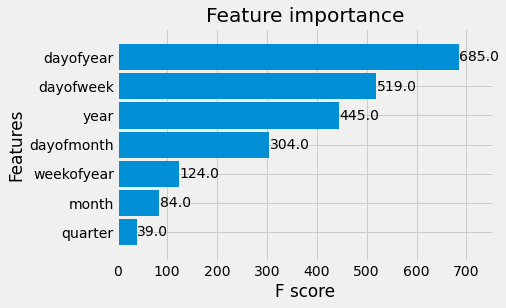

In [9]:
plot_importance(XGB_T, height=0.9)


In [10]:
Data_Take_Test['Takeaway Amount Prediction'] = XGB_T.predict(X_Test_R)
Data_Take_all = pd.concat([Data_Take_Test, Data_Take_Train], sort=False)


<AxesSubplot:xlabel='Date'>

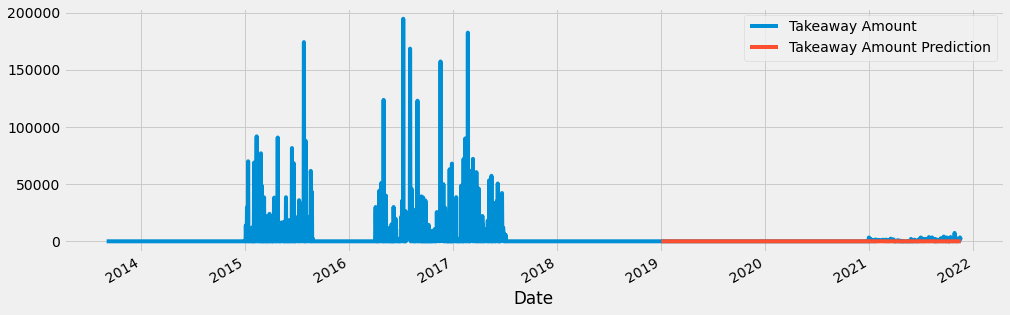

In [11]:
Data_Take_all[['Takeaway Amount', 'Takeaway Amount Prediction']].plot(
    figsize=(15, 5))


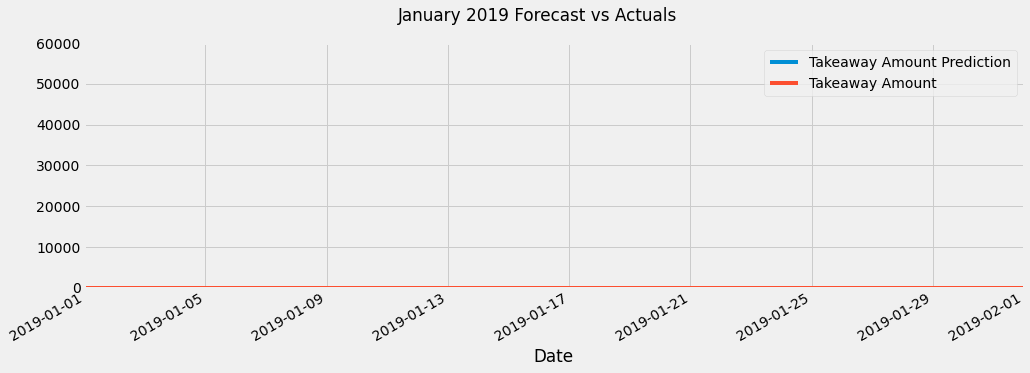

In [12]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
Data_Take_all[['Takeaway Amount Prediction', 'Takeaway Amount']].plot(ax=ax,
                                                style=['-', '-'])
ax.set_xbound(lower='01-01-2019', upper='02-01-2019')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2019 Forecast vs Actuals')


In [13]:
mean_squared_error(y_true=Data_Take_Test['Takeaway Amount'],
                   y_pred=Data_Take_Test['Takeaway Amount Prediction'])


542139.2323292865

In [14]:
mean_absolute_error(y_true=Data_Take_Test['Takeaway Amount'],
                    y_pred=Data_Take_Test['Takeaway Amount Prediction'])


271.7642774804082

In [15]:
Data_Take_Test['error'] = Data_Take_Test['Takeaway Amount'] - \
    Data_Take_Test['Takeaway Amount Prediction']
Data_Take_Test['abs_error'] = Data_Take_Test['error'].apply(np.abs)
error_by_day = Data_Take_Test.groupby(['year', 'month', 'dayofmonth']) \
    .mean()[['Takeaway Amount', 'Takeaway Amount Prediction', 'error', 'abs_error']]


In [16]:
error_by_day.sort_values('error', ascending=True).head(10)


Takeaway Amount  Takeaway Amount Prediction     error  \
year month dayofmonth                                                          
2019 1     2                         0                    0.350409 -0.350409   
2020 6     22                        0                    0.350409 -0.350409   
           23                        0                    0.350409 -0.350409   
           24                        0                    0.350409 -0.350409   
           25                        0                    0.350409 -0.350409   
           26                        0                    0.350409 -0.350409   
           27                        0                    0.350409 -0.350409   
           28                        0                    0.350409 -0.350409   
           29                        0                    0.350409 -0.350409   
           30                        0                    0.350409 -0.350409   

                       abs_error  
year month dayofmonth             
2019 1     2            0.350409  
2020 6     22           0.350409  
           23           0.350409  
           24           0.350409  
           25           0.350409  
           26           0.350409  
           27           0.350409  
           28           0.350409  
           29           0.350409  
           30           0.350409

In [17]:
error_by_day.sort_values('abs_error', ascending=False).head(10)


Takeaway Amount  Takeaway Amount Prediction  \
year month dayofmonth                                                
2021 10    28                     7320                    0.350409   
           29                     5080                    0.350409   
     9     20                     4155                    0.350409   
     10    30                     4020                    0.350409   
     7     30                     3700                    0.350409   
     10    14                     3690                    0.350409   
           13                     3400                    0.350409   
     11    16                     3370                    0.350409   
     8     10                     3360                    0.350409   
     9     30                     3350                    0.350409   

                             error    abs_error  
year month dayofmonth                            
2021 10    28          7319.649591  7319.649591  
           29          5079.649591  5079.649591  
     9     20          4154.649591  4154.649591  
     10    30          4019.649591  4019.649591  
     7     30          3699.649591  3699.649591  
     10    14          3689.649591  3689.649591  
           13          3399.649591  3399.649591  
     11    16          3369.649591  3369.649591  
     8     10          3359.649591  3359.649591  
     9     30          3349.649591  3349.649591

In [18]:
error_by_day.sort_values('abs_error', ascending=True).head(10)


Takeaway Amount  Takeaway Amount Prediction     error  \
year month dayofmonth                                                          
2019 1     2                         0                    0.350409 -0.350409   
2020 6     22                        0                    0.350409 -0.350409   
           23                        0                    0.350409 -0.350409   
           24                        0                    0.350409 -0.350409   
           25                        0                    0.350409 -0.350409   
           26                        0                    0.350409 -0.350409   
           27                        0                    0.350409 -0.350409   
           28                        0                    0.350409 -0.350409   
           29                        0                    0.350409 -0.350409   
           30                        0                    0.350409 -0.350409   

                       abs_error  
year month dayofmonth             
2019 1     2            0.350409  
2020 6     22           0.350409  
           23           0.350409  
           24           0.350409  
           25           0.350409  
           26           0.350409  
           27           0.350409  
           28           0.350409  
           29           0.350409  
           30           0.350409